# **Librerias**

In [1]:
# Importamos 

import torch 
import warnings
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR, OneCycleLR, CosineAnnealingLR, PolynomialLR,SequentialLR
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ConstantLR, LinearLR, ExponentialLR, ChainedScheduler, CosineAnnealingWarmRestarts

# Verbose 

warnings.filterwarnings(action = 'ignore', category = UserWarning)

# Version 

print(f'Numpy Version: {np.__version__}')
print(f'Torch Version: {torch.__version__}')
print(f'Matplotlib Version: {matplotlib.__version__}')

Numpy Version: 2.0.2
Torch Version: 2.6.0+cpu
Matplotlib Version: 3.9.4


# **Funcion de Perdidas**

$$L(\theta) = (x^2 - 1)^2 + (y^2 - 1)^2 + 1.5 \cdot \sin({7 \cdot x}) \cdot \sin({5.5 \cdot y})$$

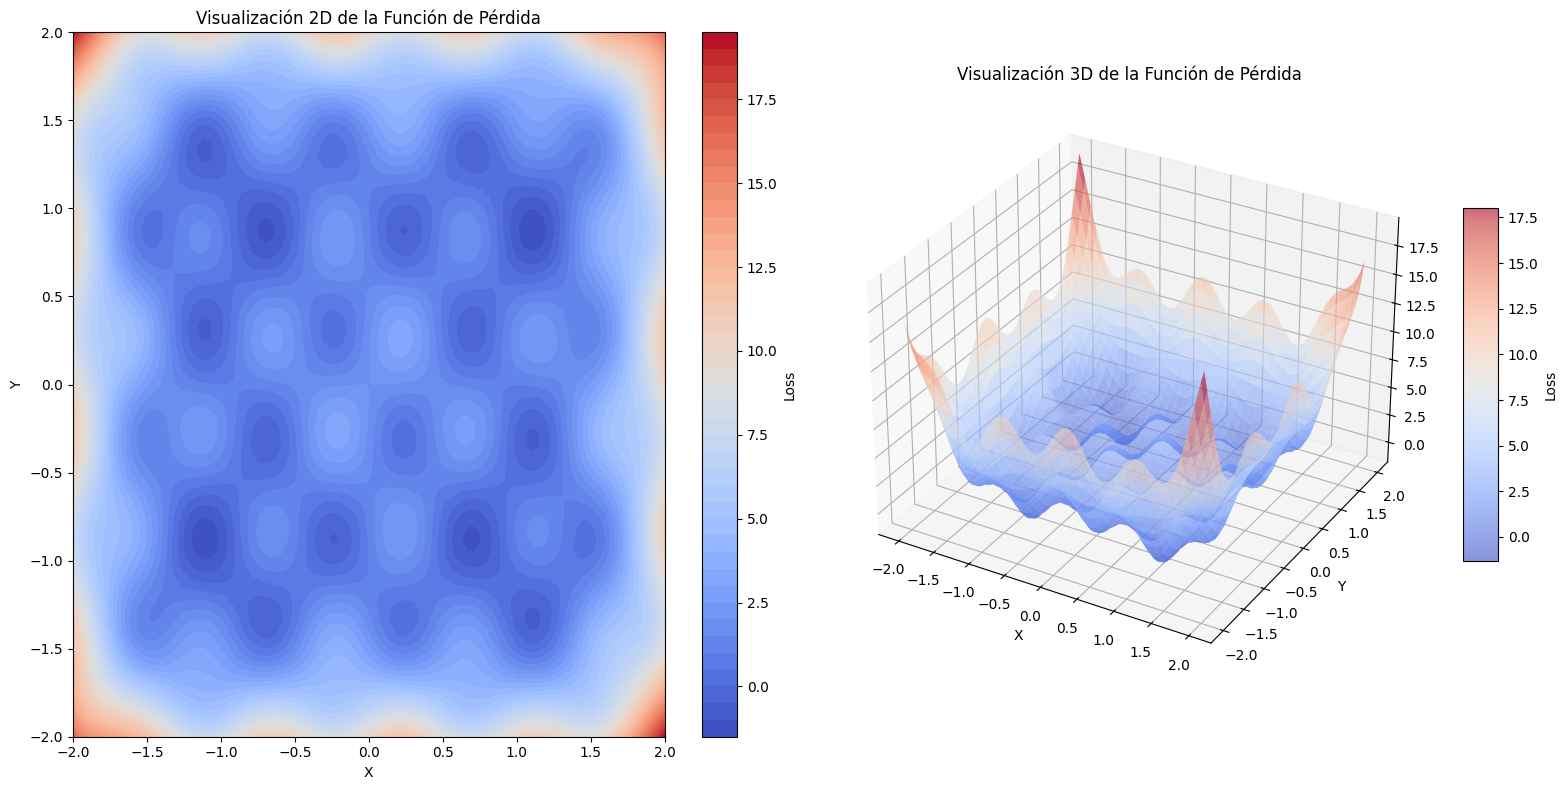

In [2]:
# Funcion de Perdidas 

def loss_function(x, y):
    
    loss = (x**2 - 1)**2 + (y**2 - 1)**2 + 1.5 * torch.sin(7 * x) * torch.sin(5.5 * y)
    
    return loss

# Funcion de Visualizacion de la Funcion de Perdidas

def plot_loss_fn(X, Y, Z):

    fig = plt.figure(figsize = (16, 8))

    ax1 = fig.add_subplot(1, 2, 1)
    contour = ax1.contourf(X, Y, Z, levels = 50, cmap = 'coolwarm')
    fig.colorbar(contour, ax = ax1, label = 'Loss')
    ax1.set_title('Visualización 2D de la Función de Pérdida')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')

    ax2 = fig.add_subplot(1, 2, 2, projection = '3d')
    surf = ax2.plot_surface(X, Y, Z, cmap = 'coolwarm', edgecolor = 'none', alpha = 0.6)
    fig.colorbar(surf, ax = ax2, shrink = 0.5, aspect = 10, label = 'Loss')
    ax2.set_title('Visualización 3D de la Función de Pérdida')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    
    plt.tight_layout()

    return plt.show()

# Visualizamos

x = torch.linspace(start = -2, end = 2, steps = 100)
y = torch.linspace(start = -2, end = 2, steps = 100)

X, Y = torch.meshgrid(x, y)

Z = loss_function(X, Y)

plot_loss_fn(X, Y, Z)

# **Sin Ajuste Learning Rate**

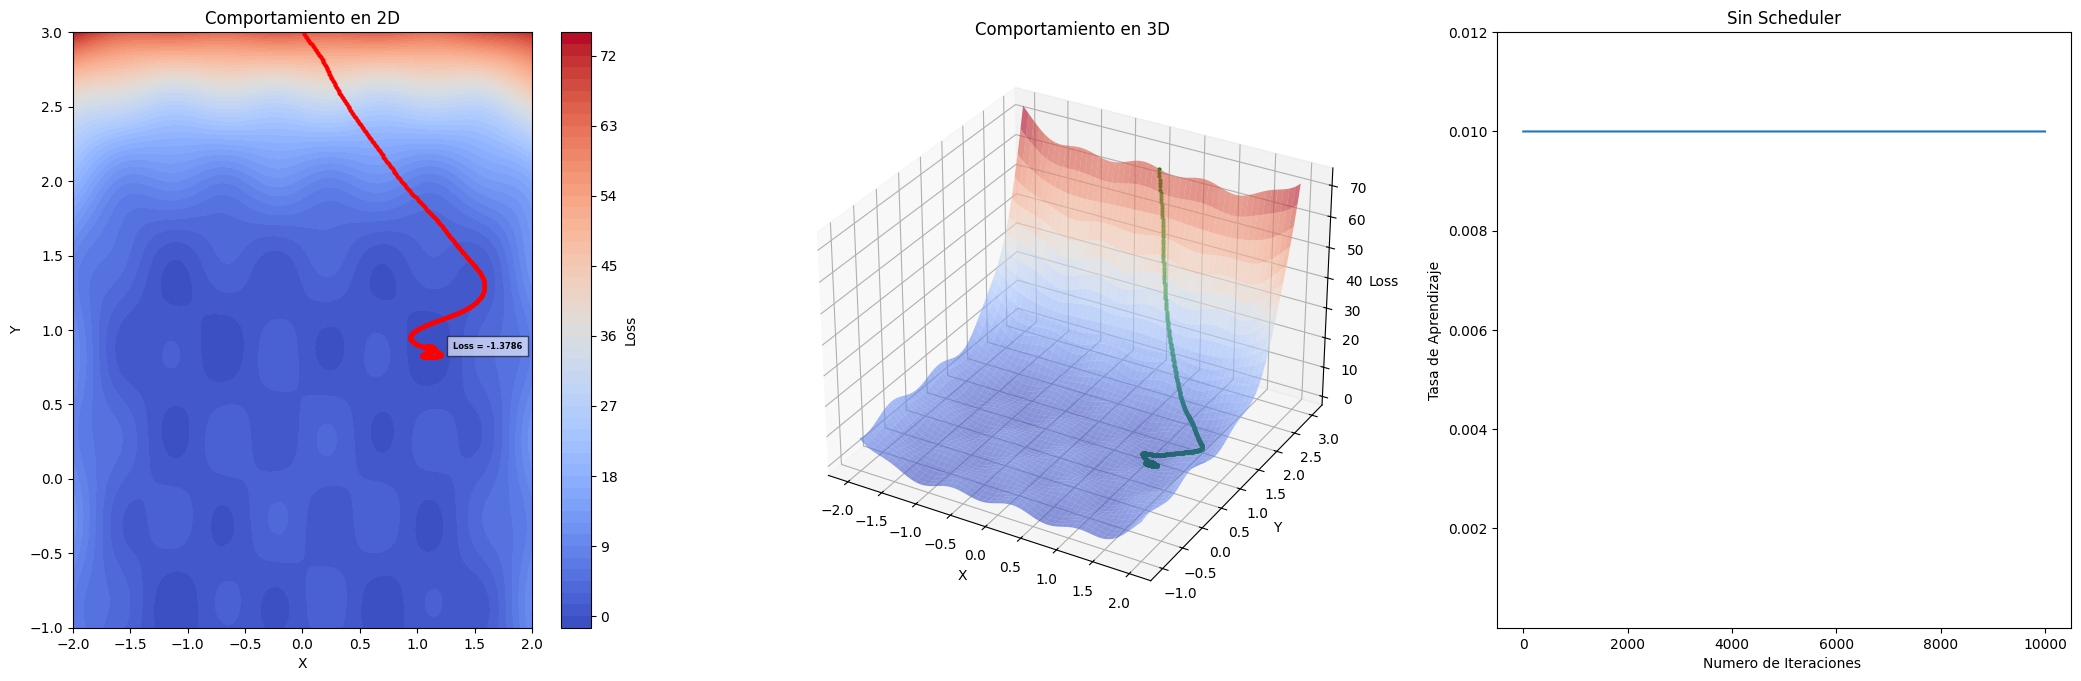

In [3]:
# Funcion de Entrenamiento

def train_fuction(n_iterations, optimizer, scheduler = None):
    
    grad_values = []
    loss_values = []
    params_values = []
    learning_rate_values = []

    for idx in range(n_iterations):

        loss = loss_function(params[0], params[1])
        
        loss.backward()   
        
        optimizer.step()  
        
        loss_values.append(loss.item()) 
        params_values.append(params.clone().detach().numpy())  
        grad_values.append(params.grad.clone().detach().numpy())
        learning_rate_values.append(optimizer.state_dict()['param_groups'][0]['lr'])        
        
        optimizer.zero_grad()  
        
        if scheduler is not None: 
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(metrics = loss)
            else:
                scheduler.step()
        
    grad_values = np.array(grad_values)
    loss_values = np.array(loss_values)
    params_values = np.array(params_values)
    learning_rate_values = np.array(learning_rate_values)

    return loss_values, params_values, grad_values, learning_rate_values

# Funcion de Visualizacion

def plot_function(loss, params, learning_rates, loss_fn, n_iterations, name = ''):

    X = np.linspace(-2, 2, 400)
    Y = np.linspace(-1, 3, 400)
    
    X, Y = np.meshgrid(X, Y)
    
    Z = loss_fn(torch.tensor(X), torch.tensor(Y)).numpy()

    fig = plt.figure(figsize = (22, 8))

    ax1 = fig.add_subplot(1, 3, 1)
    contour = ax1.contourf(X, Y, Z, levels = 50, cmap = 'coolwarm')
    
    fig.colorbar(contour, ax = ax1, label = 'Loss')
    ax1.plot(params[:, 0], params[:, 1], marker = 'o', color = 'red', markersize = 2, linestyle = '-', linewidth = 1)
    ax1.text(params[-1, 0] + 0.2, params[-1, 1], f'Loss = {loss[-1]:0.4f}', color = 'black', fontsize = 6, weight = 'bold', bbox = dict(facecolor = 'white', alpha = 0.6))  
    ax1.set_title('Comportamiento en 2D')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')

    ax2 = fig.add_subplot(1, 3, 2, projection = '3d')
    
    ax2.plot_surface(X, Y, Z, cmap = 'coolwarm', edgecolor = 'none', alpha = 0.6)
    ax2.plot(params[:, 0], params[:, 1], loss, marker = 'o', color = 'green', markersize = 2, linestyle = '-', linewidth = 1)
    ax2.set_title('Comportamiento en 3D')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Loss')

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.plot(range(n_iterations), learning_rates)
    ax3.set_title(f'{name}')
    ax3.set_xlabel('Numero de Iteraciones ')
    ax3.set_ylabel('Tasa de Aprendizaje')
    
    ax3.set_ylim(1e-8, 0.012)
    
    plt.tight_layout(pad = 5.0)

    return plt.show()

# Calculamos 

params = torch.tensor([0.0, 3.0], requires_grad = True)

adam_optimizer = Adam(params = [params], lr = 0.01, betas = (0.99, 0.999), eps = 1e-8)
lr_scheduler = None

loss, params, grads, learning_rates = train_fuction(n_iterations = 10000, optimizer = adam_optimizer, scheduler = lr_scheduler)  

# Visualizamos 

plot_function(loss, params, learning_rates, loss_fn = loss_function, n_iterations = 10000, name = 'Sin Scheduler')

# **Step Learning Rate**

El Step Learning Rate depende de **dos parametros**:

* $\text{step\_size}$ = Cada cuantos pasos se actualiza la Tasa de Aprendizaje 

* $\gamma$ = El Factor de Escala que se le aplicara a la Tasa de Aprendizaje cuando se actualice


**En este ejemplo actualizamos cada 100 pasos**


$$lr_{step=0} = lr$$
$$lr_{step=100} = lr \cdot \gamma$$
$$lr_{step=200} = lr \cdot \gamma^2$$
$$lr_{step=300} = lr \cdot \gamma^3$$


* **Nota:** Presenta un Descenso Escalonado


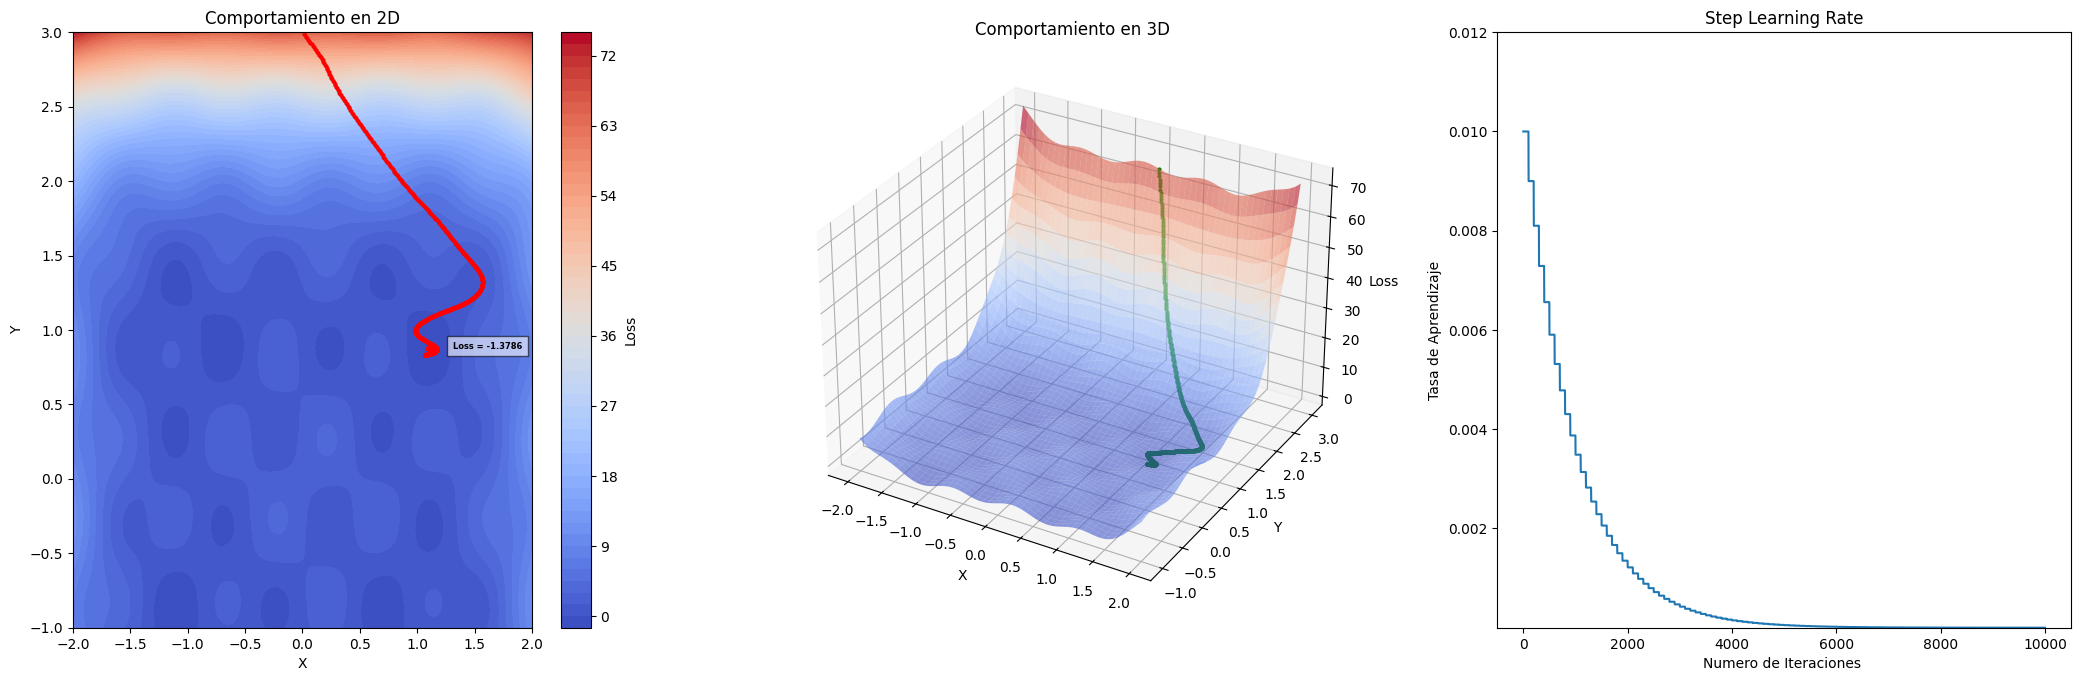

In [4]:
# Calculamos 

params = torch.tensor([0.0, 3.0], requires_grad = True)

adam_optimizer = Adam(params = [params], lr = 0.01, betas = (0.99, 0.999), eps = 1e-8)

# Scheduler 

lr_scheduler = StepLR(optimizer = adam_optimizer, step_size = 100, gamma = 0.9)

loss, params, grads, learning_rates = train_fuction(n_iterations = 10000, optimizer = adam_optimizer, scheduler = lr_scheduler)  

# Visualizamos 

plot_function(loss, params, learning_rates, loss_fn = loss_function, n_iterations = 10000, name = 'Step Learning Rate')

# **Multi Step Learning Rate**

El Multi Step Learning Rate depende de **dos parametros**:

* $\text{milestones}$ = Es una Lista que nos Indica en que paso exactos queremos que se actualice la Tasa de Aprendizaje

* $\gamma$ = El Factor de Escala que se le aplicara a la Tasa de Aprendizaje cuando se actualice


**En este ejemplo actualizamos en los pasos 100, 500, 1500, 5500 y 8500**


$$lr_{step=0} = lr$$
$$lr_{step=100} = lr \cdot \gamma$$
$$lr_{step=500} = lr \cdot \gamma^2$$
$$lr_{step=1500} = lr \cdot \gamma^3$$

* **Nota:** Presenta un Descenso Escalonado

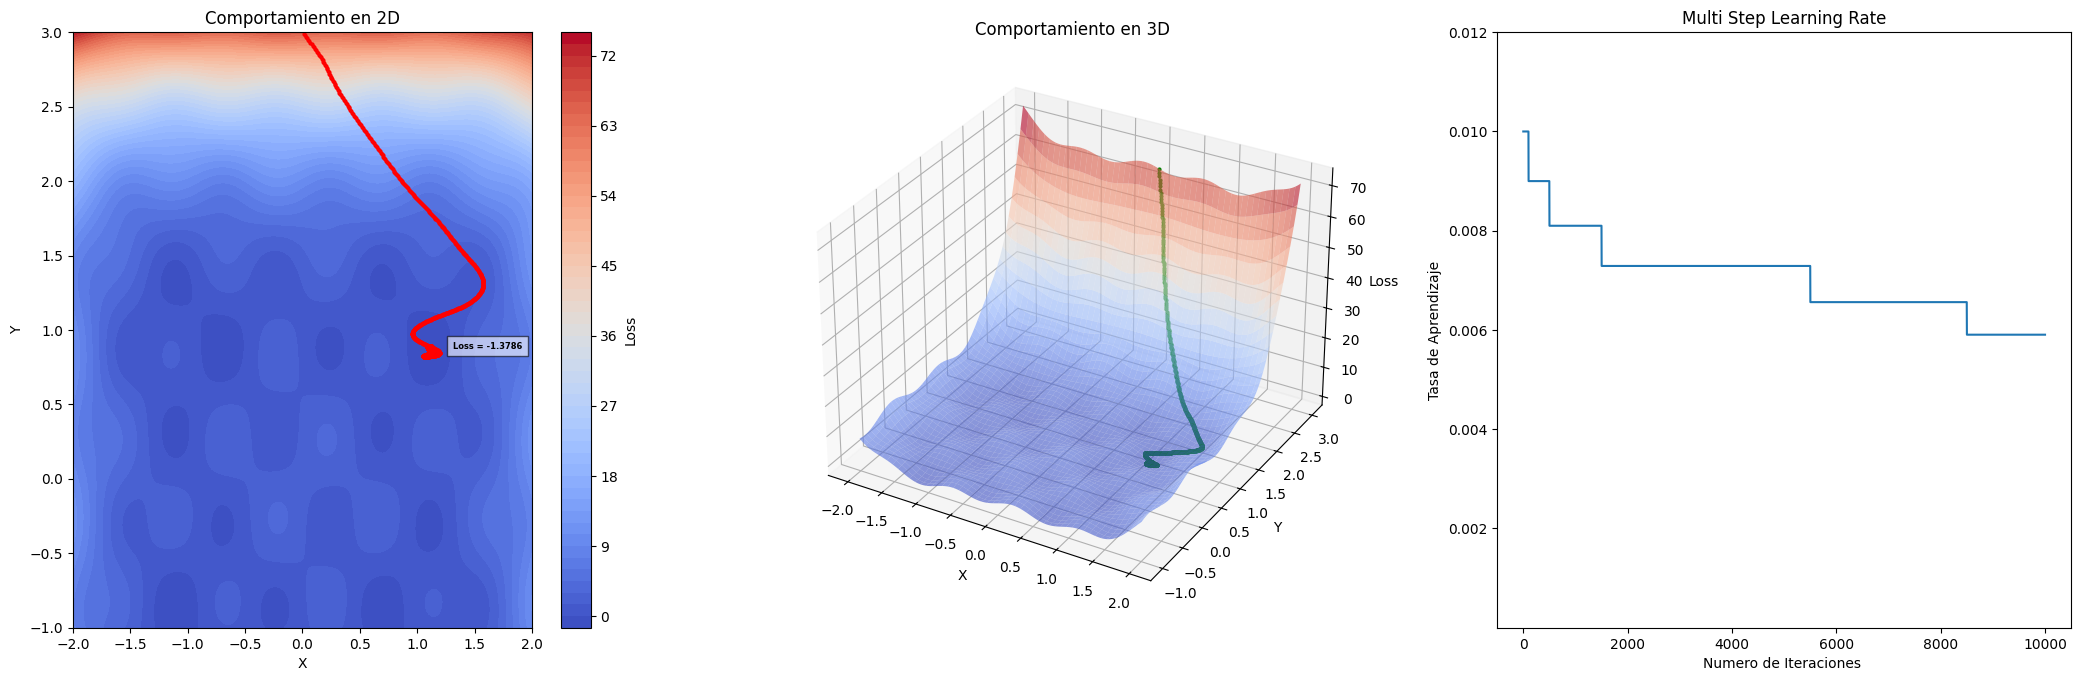

In [5]:
# Calculamos 

params = torch.tensor([0.0, 3.0], requires_grad = True)

adam_optimizer = Adam(params = [params], lr = 0.01, betas = (0.99, 0.999), eps = 1e-8)

# Scheduler 

lr_scheduler = MultiStepLR(optimizer = adam_optimizer, milestones = [100, 500, 1500, 5500, 8500], gamma = 0.9)

loss, params, grads, learning_rates = train_fuction(n_iterations = 10000, optimizer = adam_optimizer, scheduler = lr_scheduler)  

# Visualizamos 

plot_function(loss, params, learning_rates, loss_fn = loss_function, n_iterations = 10000, name = 'Multi Step Learning Rate')

# **Constant Learning Rate**

El Constant Learning Rate depende de **dos parametros**:

* $\text{factor}$ = El Factor que Escala la Tasa de Aprendizaje en un Periodo Inicial

* $\text{total\_iters}$ = El numero de iteraciones que mantendremos la Tasa de Aprendizaje Escalada antes de volver a la Tasa de Aprendizaje Original


**En este ejemplo la Tasa de Aprendizaje se Mantendra en un 70% del Valor Original en los primeros 1500 pasos**

$$
\text{lr}_{t} =
\begin{cases} 
\text{lr} \cdot \text{factor}, & \text{si } t \leq \text{total\_iters} \\
\text{lr} & \text{si } t > \text{total\_iters}
\end{cases}
$$

* **Nota:** Presenta un Cambio Discreto en un Punto Especifico

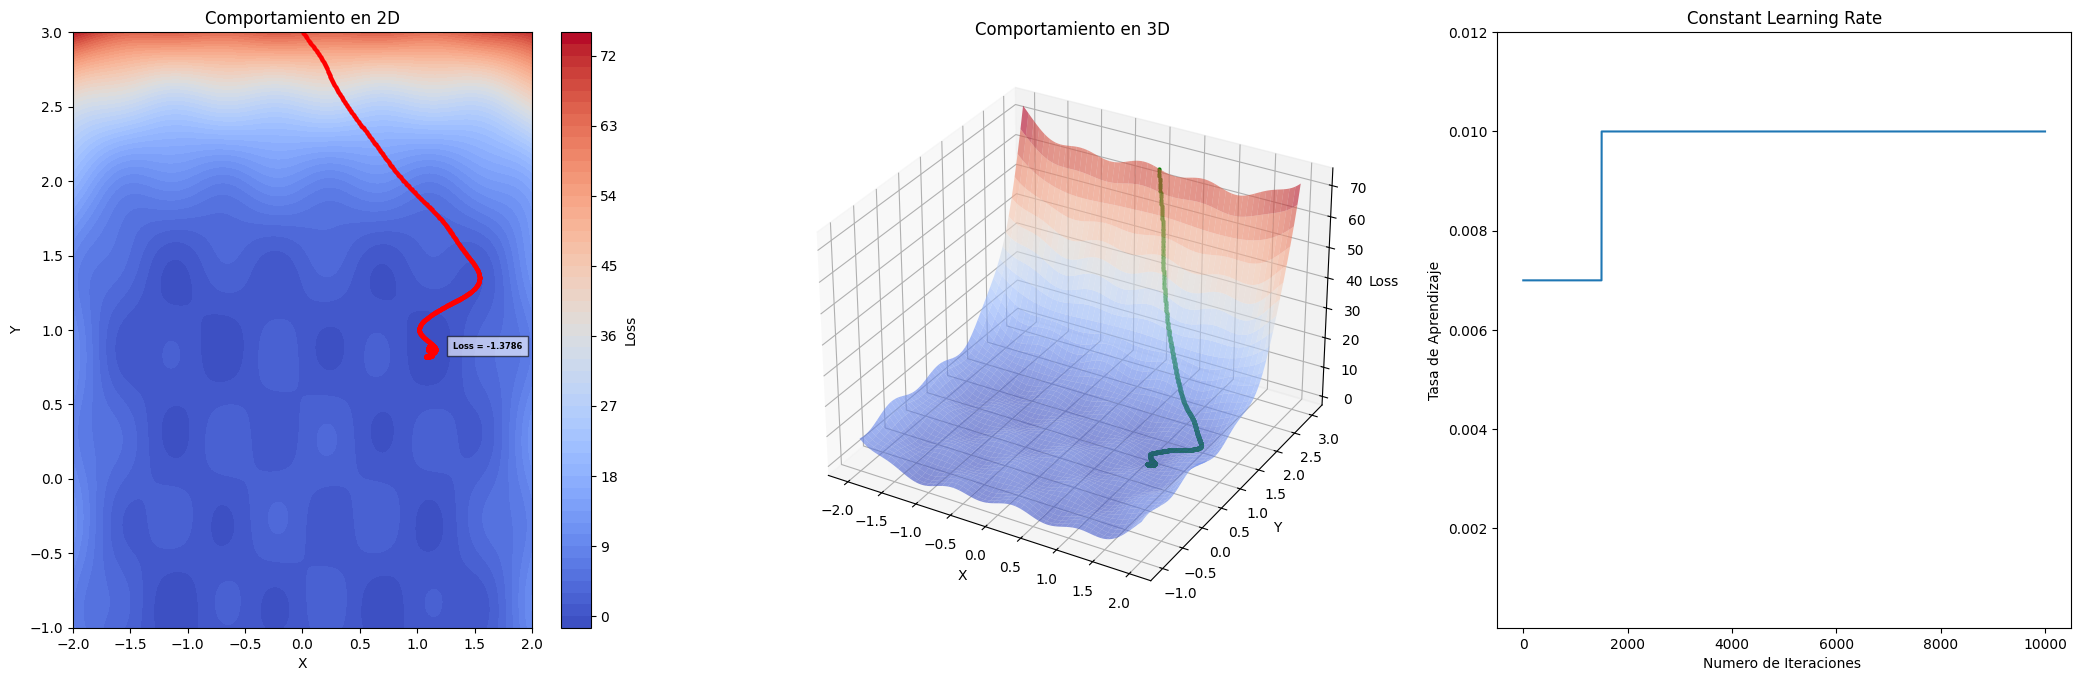

In [6]:
# Calculamos 

params = torch.tensor([0.0, 3.0], requires_grad = True)

adam_optimizer = Adam(params = [params], lr = 0.01, betas = (0.99, 0.999), eps = 1e-8)

# Scheduler 

lr_scheduler = ConstantLR(optimizer = adam_optimizer, factor = 0.7, total_iters = 1500)

loss, params, grads, learning_rates = train_fuction(n_iterations = 10000, optimizer = adam_optimizer, scheduler = lr_scheduler)  

# Visualizamos 

plot_function(loss, params, learning_rates, loss_fn = loss_function, n_iterations = 10000, name = 'Constant Learning Rate')

# **Linear Learning Rate**

El Linear Learning Rate depende de **tres parametros**:

* $\text{start\_factor}$ = Define el Factor de Escala que se utilizara en el Inicio de la Disminucion Lineal de la Tasa de Aprendizaje

* $\text{end\_factor}$ = Define el Factor de Escala que se utilizara en el Final de la Disminucion Lineal de la Tasa de Aprendizaje

* $\text{total\_iters}$ = El numero de iteraciones que disminuiremos la Tasa de Aprendizaje de Manera Lineal


**En este ejemplo, la tasa de aprendizaje disminuirá linealmente desde el valor original escalado por `start_factor` hasta el valor original escalado por `end_factor` en los primeros 1500 pasos.**

$$
\text{lr}_t = \text{lr} \cdot \left( \text{start\_factor} + \left( \text{end\_factor} - \text{start\_factor} \right) \cdot \frac{t}{\text{total\_iters}} \right)
$$

* **Nota:** Presenta un Comportamiento de Disminucion Lineal durante las Primeras Iteraciones Definidas

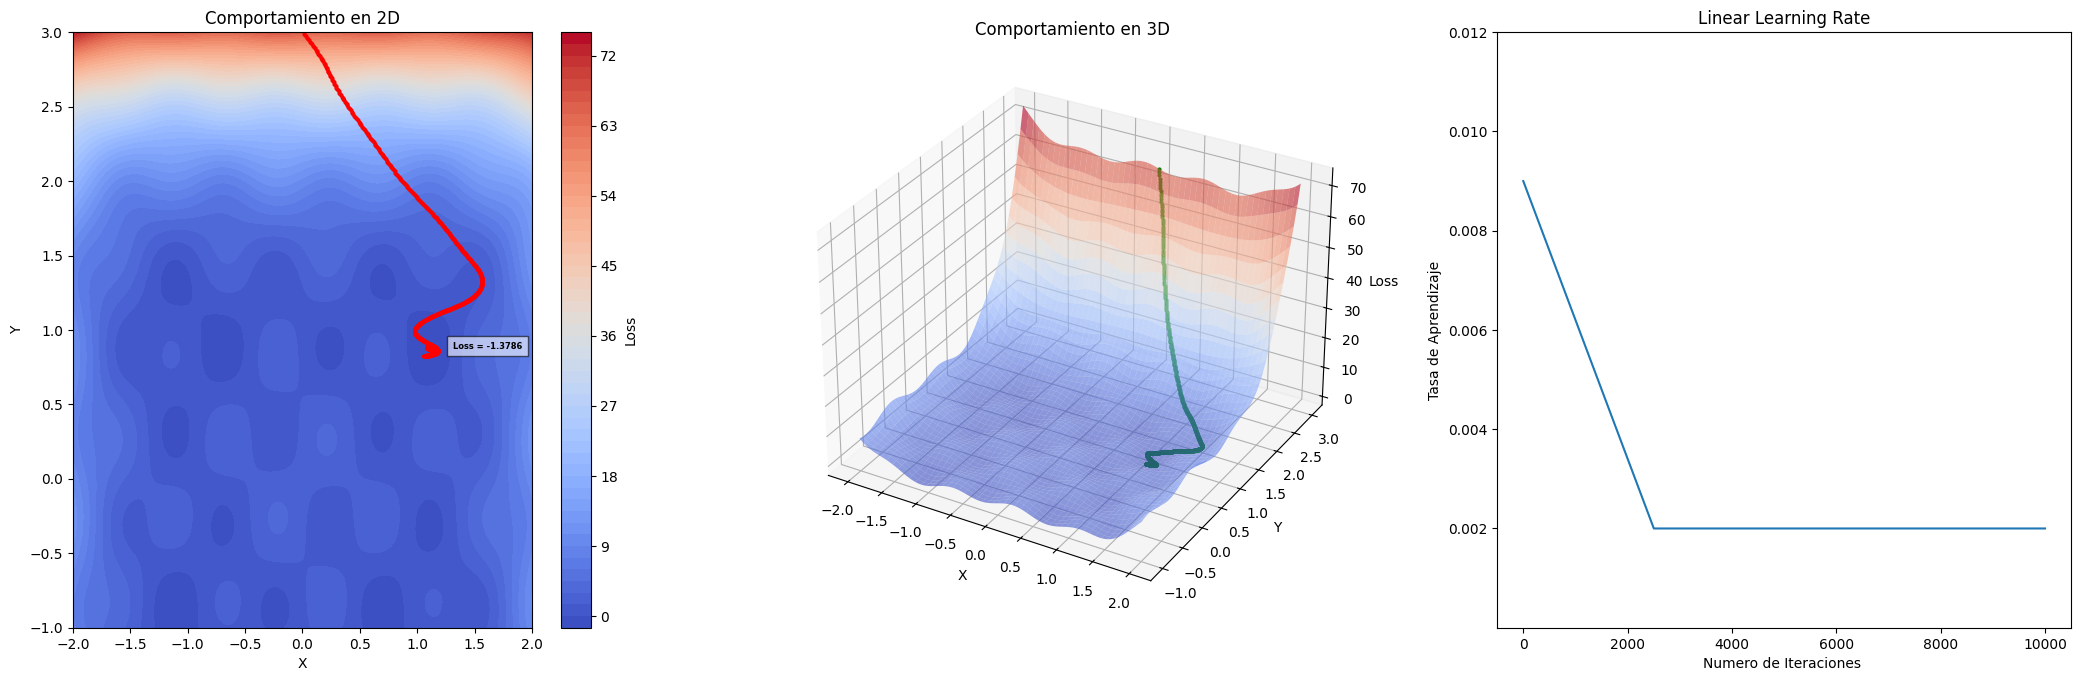

In [7]:
# Calculamos 

params = torch.tensor([0.0, 3.0], requires_grad = True)

adam_optimizer = Adam(params = [params], lr = 0.01, betas = (0.99, 0.999), eps = 1e-8)

# Scheduler 

lr_scheduler = LinearLR(optimizer = adam_optimizer, start_factor = 0.9, end_factor = 0.2, total_iters = 2500)

loss, params, grads, learning_rates = train_fuction(n_iterations = 10000, optimizer = adam_optimizer, scheduler = lr_scheduler)  

# Visualizamos 

plot_function(loss, params, learning_rates, loss_fn = loss_function, n_iterations = 10000, name = 'Linear Learning Rate')

# **Exponential Learning Rate**

El Exponential Learning Rate depende de **un parametro**:

* $\gamma$ = El Factor de Escala que se le aplicara a la Tasa de Aprendizaje cuando se actualice


**En este ejemplo actualizamos en cada paso**

$$lr_{step=0} = lr$$
$$lr_{step=1} = lr \cdot \gamma$$
$$lr_{step=2} = lr \cdot \gamma^2$$
$$lr_{step=3} = lr \cdot \gamma^3$$

$$lr_{step=t} = lr \cdot \gamma^t$$


* **Nota:** Presenta un Descenso Continuo y Suave

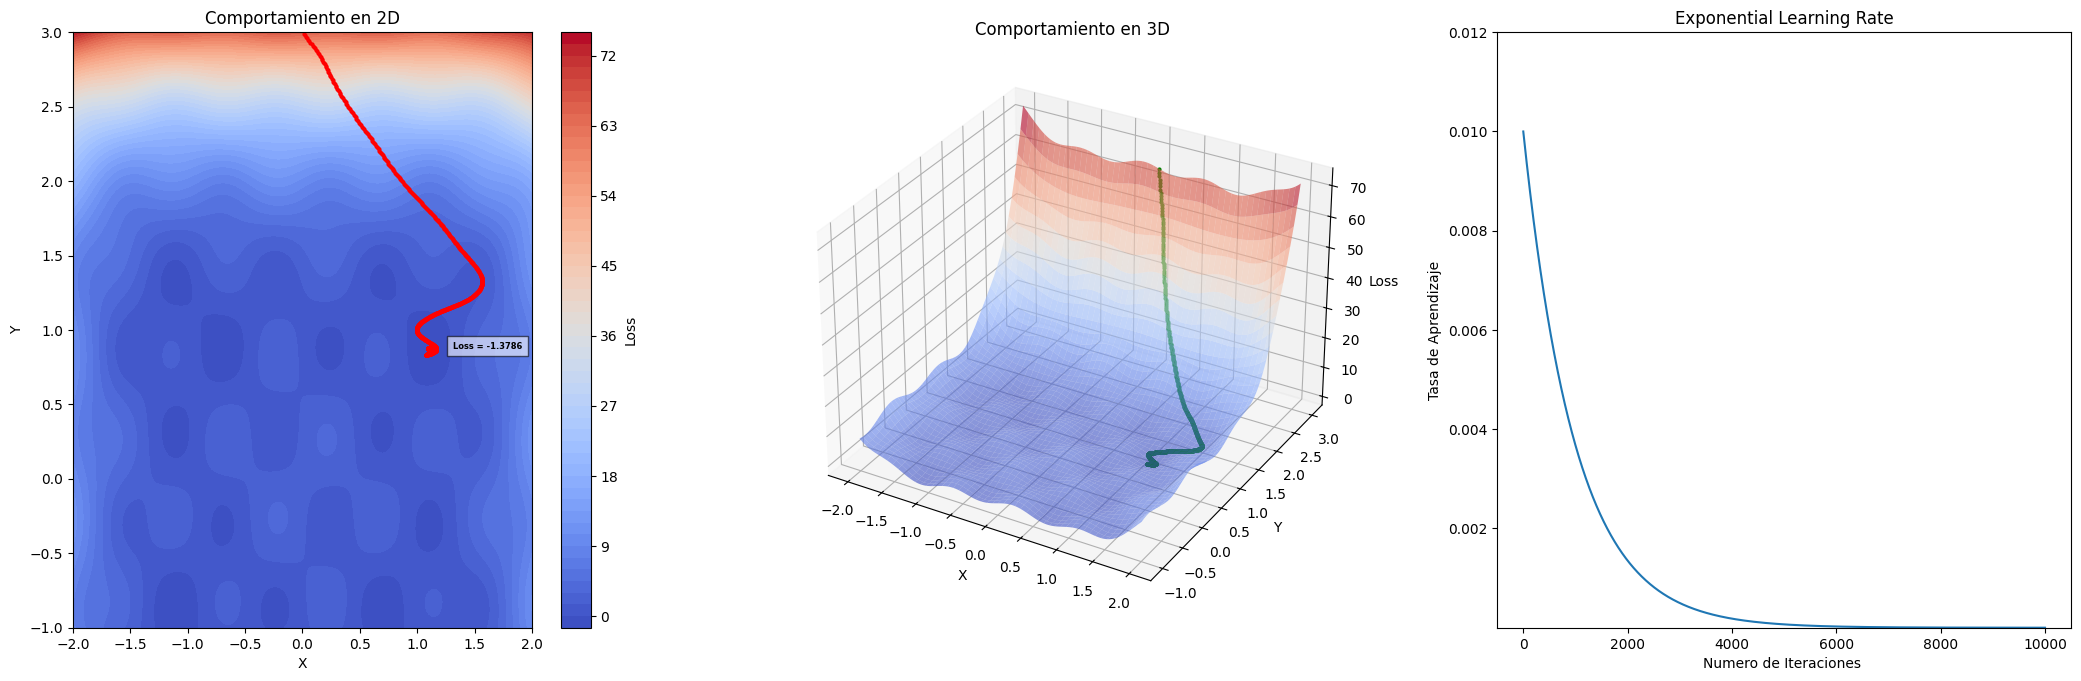

In [8]:
# Calculamos 

params = torch.tensor([0.0, 3.0], requires_grad = True)

adam_optimizer = Adam(params = [params], lr = 0.01, betas = (0.99, 0.999), eps = 1e-8)

# Scheduler 

lr_scheduler = ExponentialLR(optimizer = adam_optimizer, gamma = 0.999)

loss, params, grads, learning_rates = train_fuction(n_iterations = 10000, optimizer = adam_optimizer, scheduler = lr_scheduler)  

# Visualizamos 

plot_function(loss, params, learning_rates, loss_fn = loss_function, n_iterations = 10000, name = 'Exponential Learning Rate')

# **Polynomial Learning Rate**

El Polynomial Learning Rate depende de **dos parametros**:

* $\text{power}$ = Es el Exponente que Indica la Rapidez del Decaimiento de la Tasa de Aprendizaje

* $\text{total\_iters}$ = El numero de iteraciones en el que se aplica el decaimiento desde el inicio


**En este ejemplo la Tasa de Aprendizaje disminuye a cero en el Paso 8500**

$$
\text{lr}_{t} = lr \cdot \left( 1 - \frac{t}{\text{total\_iters}} \right)^\text{power}
$$

El descenso es Lineal: $\text{power} = 1$ 

El descenso es Concavo: $\text{power} > 1$

El descenso es Convexo: $0 < \text{power} < 1$ 

* **Nota:** Presenta un Cambio Suave

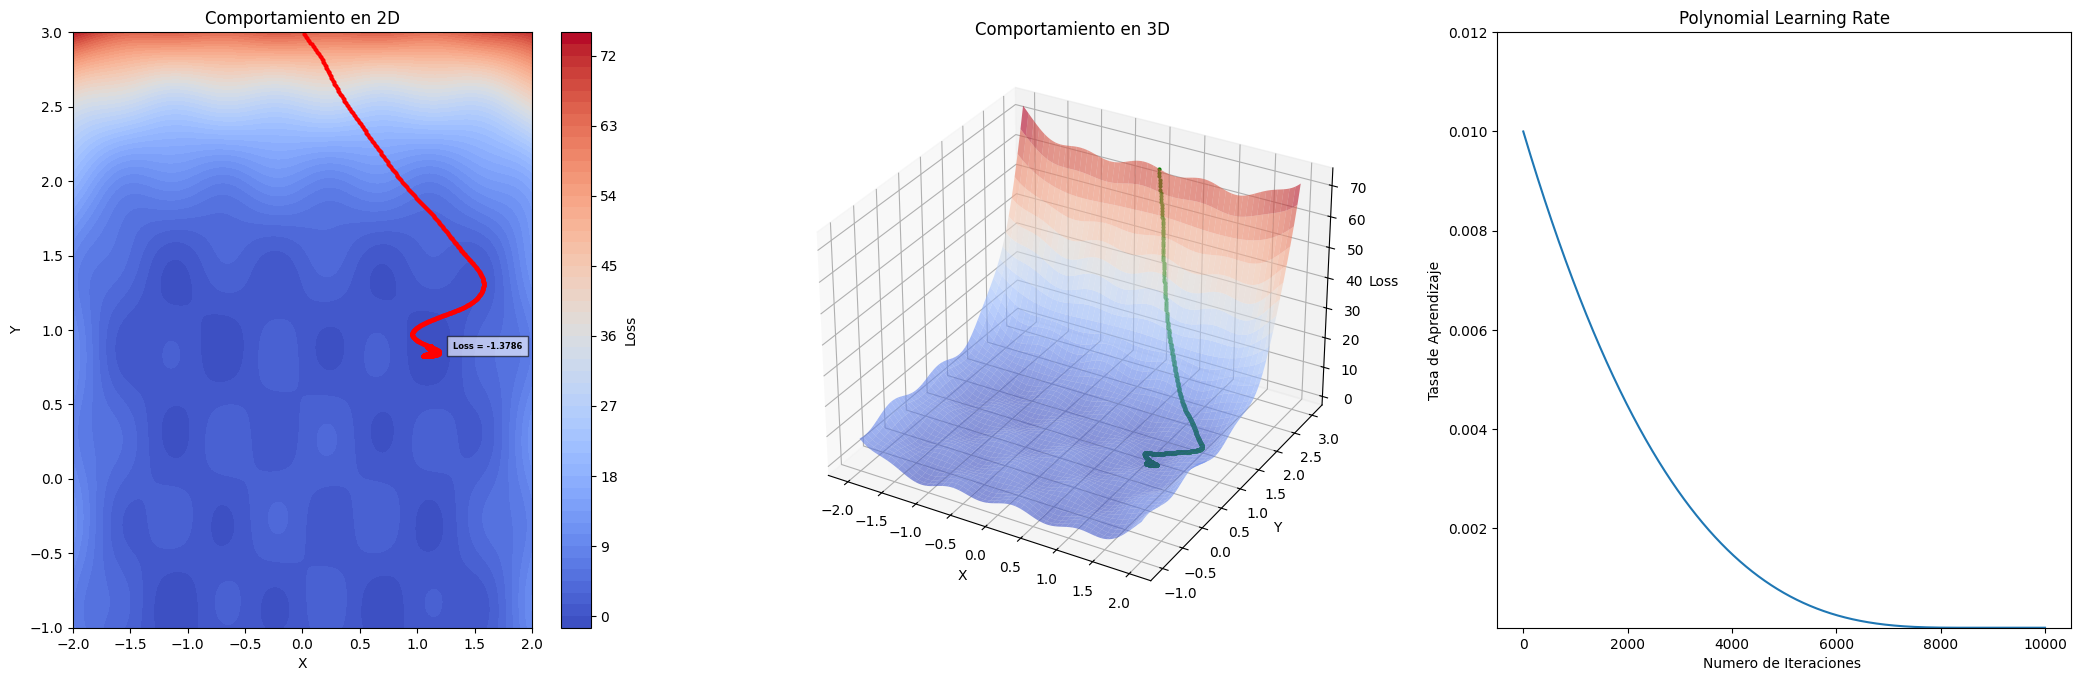

In [9]:
# Calculamos 

params = torch.tensor([0.0, 3.0], requires_grad = True)

adam_optimizer = Adam(params = [params], lr = 0.01, betas = (0.99, 0.999), eps = 1e-8)

# Scheduler 

lr_scheduler = PolynomialLR(optimizer = adam_optimizer, power = 3, total_iters = 8500)

loss, params, grads, learning_rates = train_fuction(n_iterations = 10000, optimizer = adam_optimizer, scheduler = lr_scheduler)  

# Visualizamos 

plot_function(loss, params, learning_rates, loss_fn = loss_function, n_iterations = 10000, name = 'Polynomial Learning Rate')

# **Cosine Annealing Learning Rate**

El Cosine Annealing Learning Rate depende de **dos parametros**:

* $\text{eta\_min}$ = Es el valor minimo que alcanzara la Tasa de Aprendizaje al final del ciclo cosenoidal.

* $\text{T\_max}$ = El numero de iteraciones que tarda la Tasa de Aprendizaje en descender desde su valor inicial hasta `eta_min`

**En este ejemplo la Tasa de Aprendizaje disminuye desde la Tasa Original al Valor minimo `eta_min` cada `T_max` iteraciones**

$$
\text{lr}_t = \eta_{\min} + \frac{1}{2} (\text{lr} - \eta_{\min}) \left(1 + \cos\left(\frac{t}{T_{\max}} \pi\right) \right)
$$

* **Nota:** Presenta un Descenso Cosenoidal

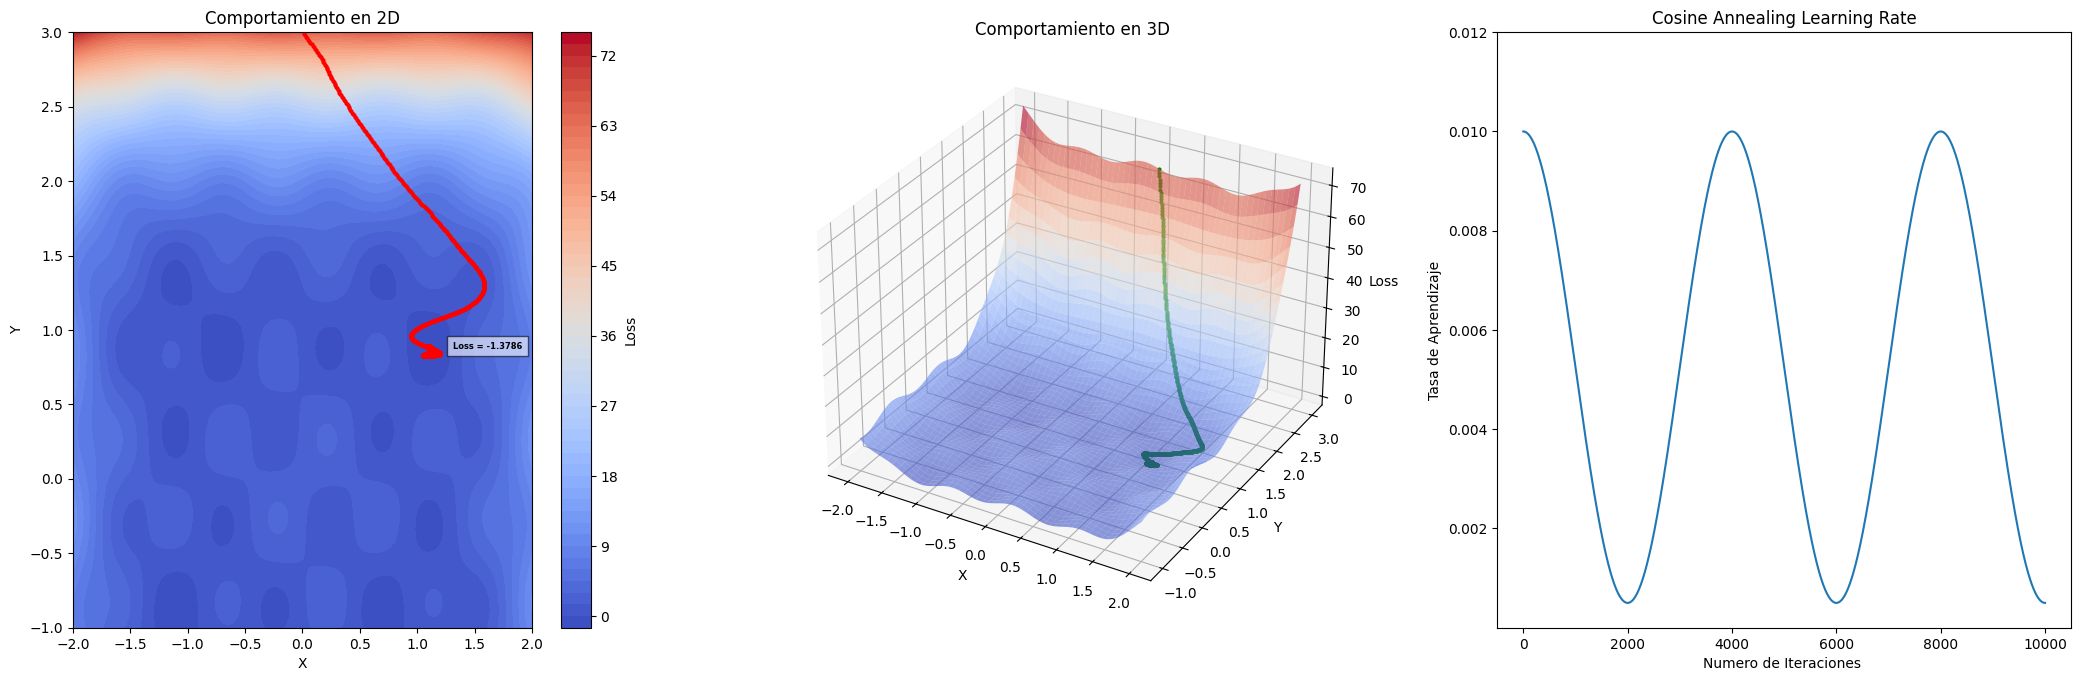

In [10]:
# Calculamos 

params = torch.tensor([0.0, 3.0], requires_grad = True)

adam_optimizer = Adam(params = [params], lr = 0.01, betas = (0.99, 0.999), eps = 1e-8)

# Scheduler 

lr_scheduler = CosineAnnealingLR(optimizer = adam_optimizer, eta_min = 0.0005, T_max = 2000)

loss, params, grads, learning_rates = train_fuction(n_iterations = 10000, optimizer = adam_optimizer, scheduler = lr_scheduler)  

# Visualizamos 

plot_function(loss, params, learning_rates, loss_fn = loss_function, n_iterations = 10000, name = 'Cosine Annealing Learning Rate')

# **Reduce Learning Rate On Plateau** 

El Reduce Learning Rate On Plateau depende de **siete parametros**:

* $\text{mode}$ = Indicamos con que comportamiento actualizamos la Tasa de Aprendizaje cuando deja de mejorar la metrica (Si cuando deja de disminuir `min`, o deja de aumentar `max`)
* $\text{factor}$ = Es el factor con el que se actualizara la Tasa de Aprendizaje cuando deje de mejorar nuestra metrica 
* $\text{patience}$ = El numero de iteraciones que se espera sin mejora en la Metrica antes de aplicar la reduccion en la Tasa de Aprendizaje
* $\text{threshold}$ = El umbral que indica si una mejora en la métrica es suficientemente significativa para considerar que se ha producido una mejora 
* $\text{threshold\_mode}$ = Como se interpreta el threshold, si como un porcentaje relativo con respecto a la metrica anterior `rel` o como un valor absoluto con respecto a la metrica anterior `abs`
* $\text{cooldown}$ = Es el número de iteraciones que el scheduler espera después de una reducción en la tasa de aprendizaje antes de aplicar otra reducción.
* $\text{min\_lr}$ = Es el valor mínimo que la tasa de aprendizaje puede alcanzar.

**En este ejemplo, la tasa de aprendizaje disminuirá si la pérdida no mejora en 75 iteraciones, con un factor de reducción de 0.99.**

$$lr = lr_{old} \cdot \gamma$$



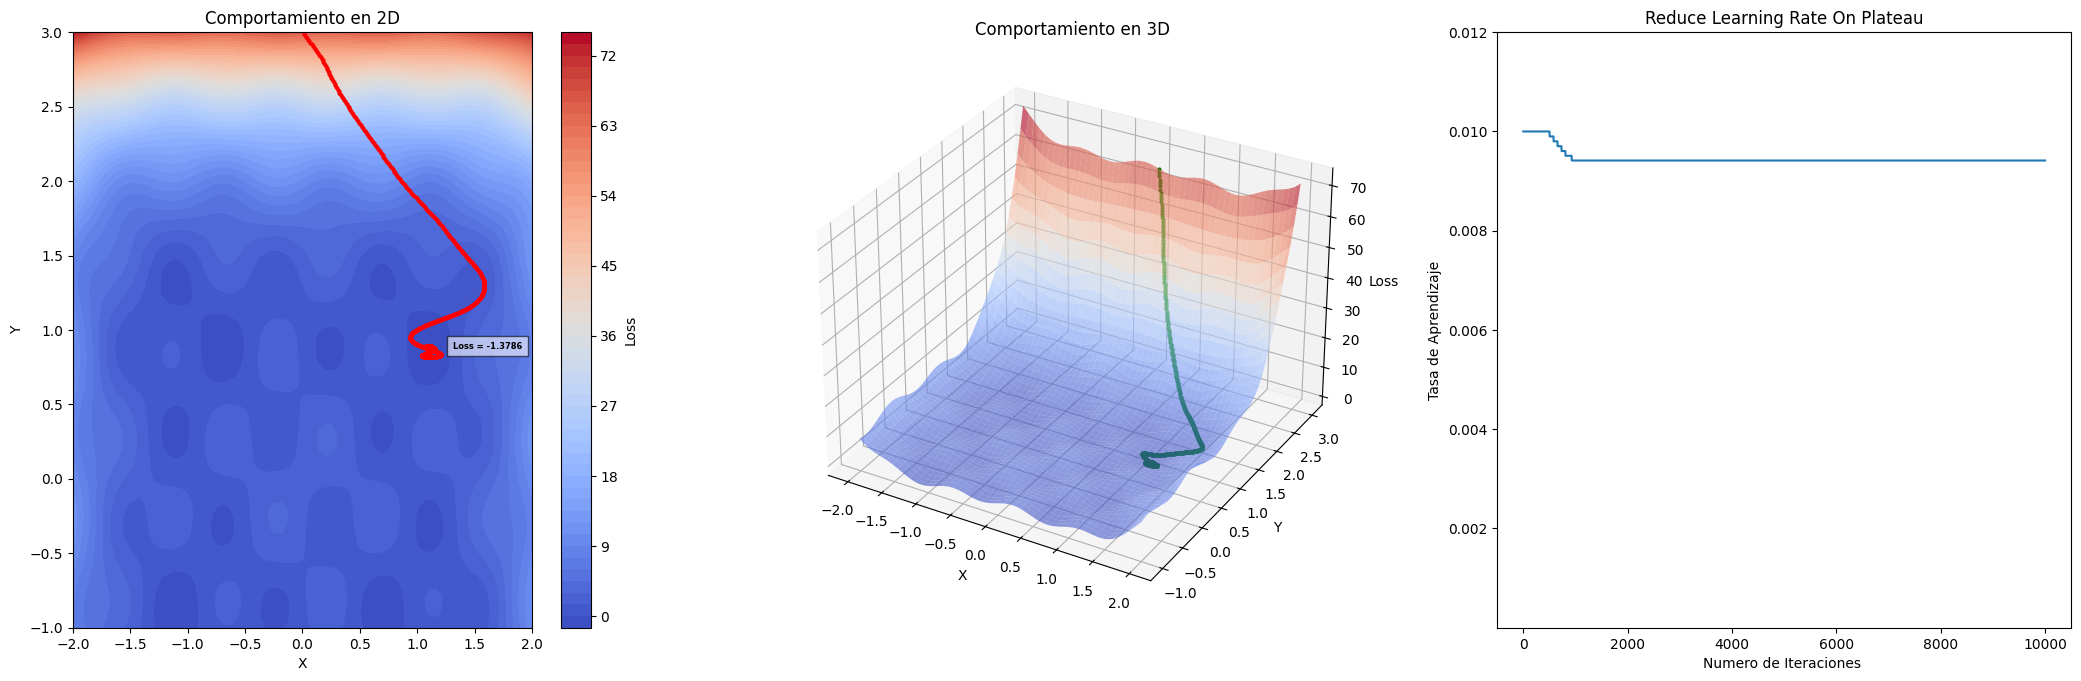

In [11]:
# Calculamos 

params = torch.tensor([0.0, 3.0], requires_grad = True)

adam_optimizer = Adam(params = [params], lr = 0.01, betas = (0.99, 0.999), eps = 1e-8)

# Scheduler 

lr_scheduler = ReduceLROnPlateau(optimizer = adam_optimizer, mode = 'min', factor = 0.99, patience = 75, threshold = 0.0001, threshold_mode = 'rel', cooldown = 0, min_lr = 0.003)

loss, params, grads, learning_rates = train_fuction(n_iterations = 10000, optimizer = adam_optimizer, scheduler = lr_scheduler)  

# Visualizamos 

plot_function(loss, params, learning_rates, loss_fn = loss_function, n_iterations = 10000, name = 'Reduce Learning Rate On Plateau')

# **Cyclic Learning Rate** 

El Cyclic Learning Rate depende de **once parametros**:

* $\text{base\_lr}$ = Es la Tasa de Aprendizaje Minima dentro del Ciclo
* $\text{max\_lr}$ = Es la Tasa de Aprendizaje Maxima dentro del Ciclo
* $\text{step\_size\_up}$ = Numero de Iteraciones que durara en subir la Tasa de Aprendizaje desde `base_lr` hasta `max_lr`
* $\text{step\_size\_down}$ = Numero de Iteraciones que durara en bajar la Tasa de Aprendizaje desde `max_lr` hasta `base_lr`
* $\text{mode}$ = `triangular` aumenta y disminuye linealmente, `triangular2` aumenta y disminuye linealmente pero en cada ciclo se reduce la mitad la Tasa de Aprendizaje, `exp_range` aumenta y disminuye de manera exponencial
* $\text{gamma}$ = Es el Factor Exponencial, solo funciona con el mode `exp_range` $lr = lr \cdot \gamma^t$
* $\text{scale\_fn}$ = Funcion Personalizada para Escalar la Tasa de Aprendizaje en cada Ciclo
* $\text{scale\_mode}$ = Modo en que aplicamos la funcion personalizada para Escalar la Tasa de Aprendizaje, si es una vez por ciclo `cycle` o en cada iteracion `iterations`
* $\text{cycle\_momentum}$ = `True` si el optimizador usa momentum
* $\text{base\_momentum}$ = Es el valor Minimo de momentum dentro del Ciclo
* $\text{max\_momentum}$ = Es el valor Maximo de momentum dentro del Ciclo

**En este ejemplo, la tasa de aprendizaje sigue un ciclo lineal entre 0.002 y 0.01, reduciendose a la mitad en cada ciclo**


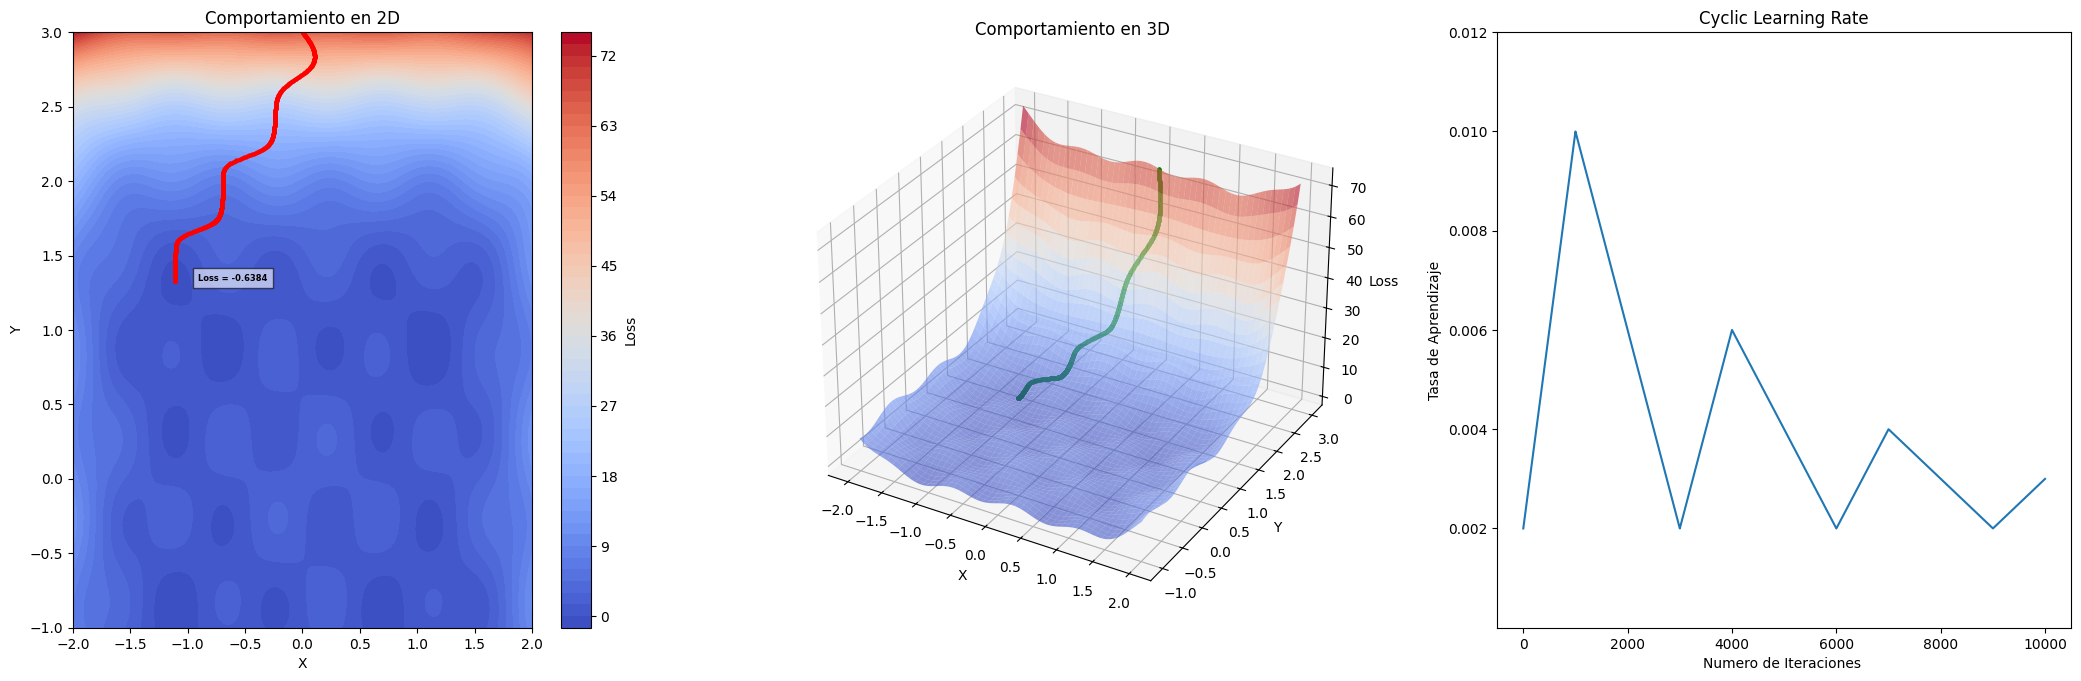

In [12]:
# Calculamos 

params = torch.tensor([0.0, 3.0], requires_grad = True)

adam_optimizer = Adam(params = [params], lr = 0.01, betas = (0.99, 0.999), eps = 1e-8)

# Scheduler 

lr_scheduler = CyclicLR(optimizer = adam_optimizer, base_lr = 0.002, max_lr = 0.01, step_size_up = 1000, step_size_down = 2000, mode = 'triangular2', gamma = 1, scale_fn = None,
                        scale_mode = 'cycle', cycle_momentum = True, base_momentum = 0.6, max_momentum = 0.8)

loss, params, grads, learning_rates = train_fuction(n_iterations = 10000, optimizer = adam_optimizer, scheduler = lr_scheduler)  

# Visualizamos 

plot_function(loss, params, learning_rates, loss_fn = loss_function, n_iterations = 10000, name = 'Cyclic Learning Rate')

# **OneCyclic Learning Rate** 

El One Cyclic Learning Rate depende de **doce parametros**:

* $\text{max\_lr}$ = Es la Tasa de Aprendizaje Maxima en el Ciclo
* $\text{total\_steps}$ = Numero Total de Iteraciones en el Entrenamiento $\text{epochs} \cdot {steps\_per\_epochs}$
* $\text{epochs}$ = Numero de Epochs en el Entrenamiento
* $\text{steps\_per\_epoch}$ = Numero de Iteraciones en un Epoch
* $\text{pct\_start}$ = Proporcion del Ciclo donde la Tasa de Aprendizaje que aumenta desde `base_lr` hasta `max_lr`
* $\text{anneal\_strategy}$ = Estrategia de reduccion de la Tasa de Aprendizaje dentro del Ciclo, puede ser `Lineal` o `Coseno` 
* $\text{cycle\_momentum}$ = `True` si el optimizador usa momentum
* $\text{base\_momentum}$ = Es el valor Minimo de momentum dentro del Ciclo
* $\text{max\_momentum}$ = Es el valor Maximo de momentum dentro del Ciclo
* $\text{div\_factor}$ = Factor de que define la Tasa de aprendizaje como $\text{lr\_base} = \frac{\text{max\_lr}}{div\_factor}$
* $\text{final\_div\_factor}$ = Factor de que define la Tasa de aprendizaje como $\text{lr\_final} = \frac{\text{base\_lr}}{final\_div\_factor}$
* $\text{three\_phase}$ = Si es `True`, el ciclo se divide entres fases, una de aumento, una de disminucion y una con la Tasa de Aprendizaje Minima

**En este ejemplo, la tasa de aprendizaje sigue un ciclo coseno donde primero aumenta hasta 0.01 y luego decae**

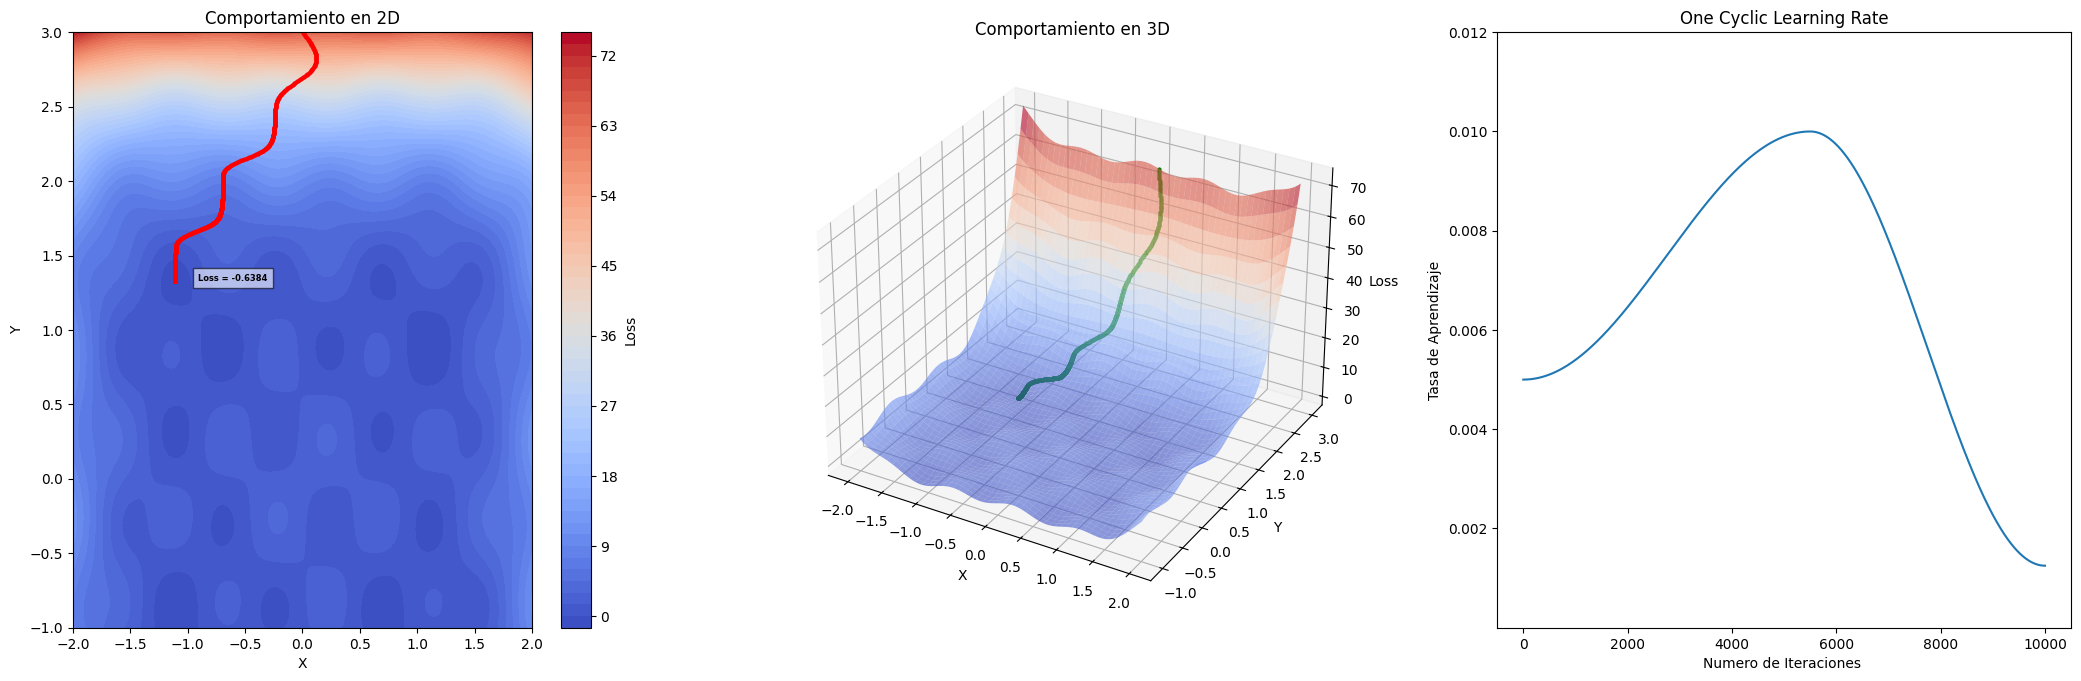

In [13]:
# Calculamos 

params = torch.tensor([0.0, 3.0], requires_grad = True)

adam_optimizer = Adam(params = [params], lr = 0.01, betas = (0.99, 0.999), eps = 1e-8)

# Scheduler 

lr_scheduler = OneCycleLR(optimizer = adam_optimizer, max_lr = 0.01, total_steps = 10000, epochs = 1, steps_per_epoch = 10000, pct_start = 0.55, anneal_strategy = 'cos', 
                          cycle_momentum = 'True', base_momentum = 0.6, max_momentum = 0.8, div_factor = 2, final_div_factor = 4, three_phase = False)

loss, params, grads, learning_rates = train_fuction(n_iterations = 10000, optimizer = adam_optimizer, scheduler = lr_scheduler)  

# Visualizamos 

plot_function(loss, params, learning_rates, loss_fn = loss_function, n_iterations = 10000, name = 'One Cyclic Learning Rate')

# **Cosine Annealing Warm Restarts Learning Rate**

El Cosine Annealing Warm Restarts Learning Rate depende de **tres parametros**:

* $\text{eta\_min}$ = Es el valor minimo que alcanzara la Tasa de Aprendizaje al final del ciclo cosenoidal.

* $T_{0}$ = El numero de iteraciones que tarda la Tasa de Aprendizaje en descender desde su valor inicial hasta `eta_min`, en cada ciclo este valor aumentara

* $T_{mult}$ = El numero multiplicativo para aumentar El numero de iteraciones que tarda la Tasa de Aprendizaje en descender desde su valor inicial hasta `eta_min` en cada ciclo

**En este ejemplo la Tasa de Aprendizaje disminuye desde la Tasa Original al Valor minimo `eta_min` en cada ciclo dinamico**

$$
\text{lr}_t = \eta_{\min} + \frac{1}{2} (\text{lr} - \eta_{\min}) \left(1 + \cos\left(\frac{t}{T_{\max}} \pi\right) \right)
$$

* **Nota:** Presenta un Descenso Cosenoidal

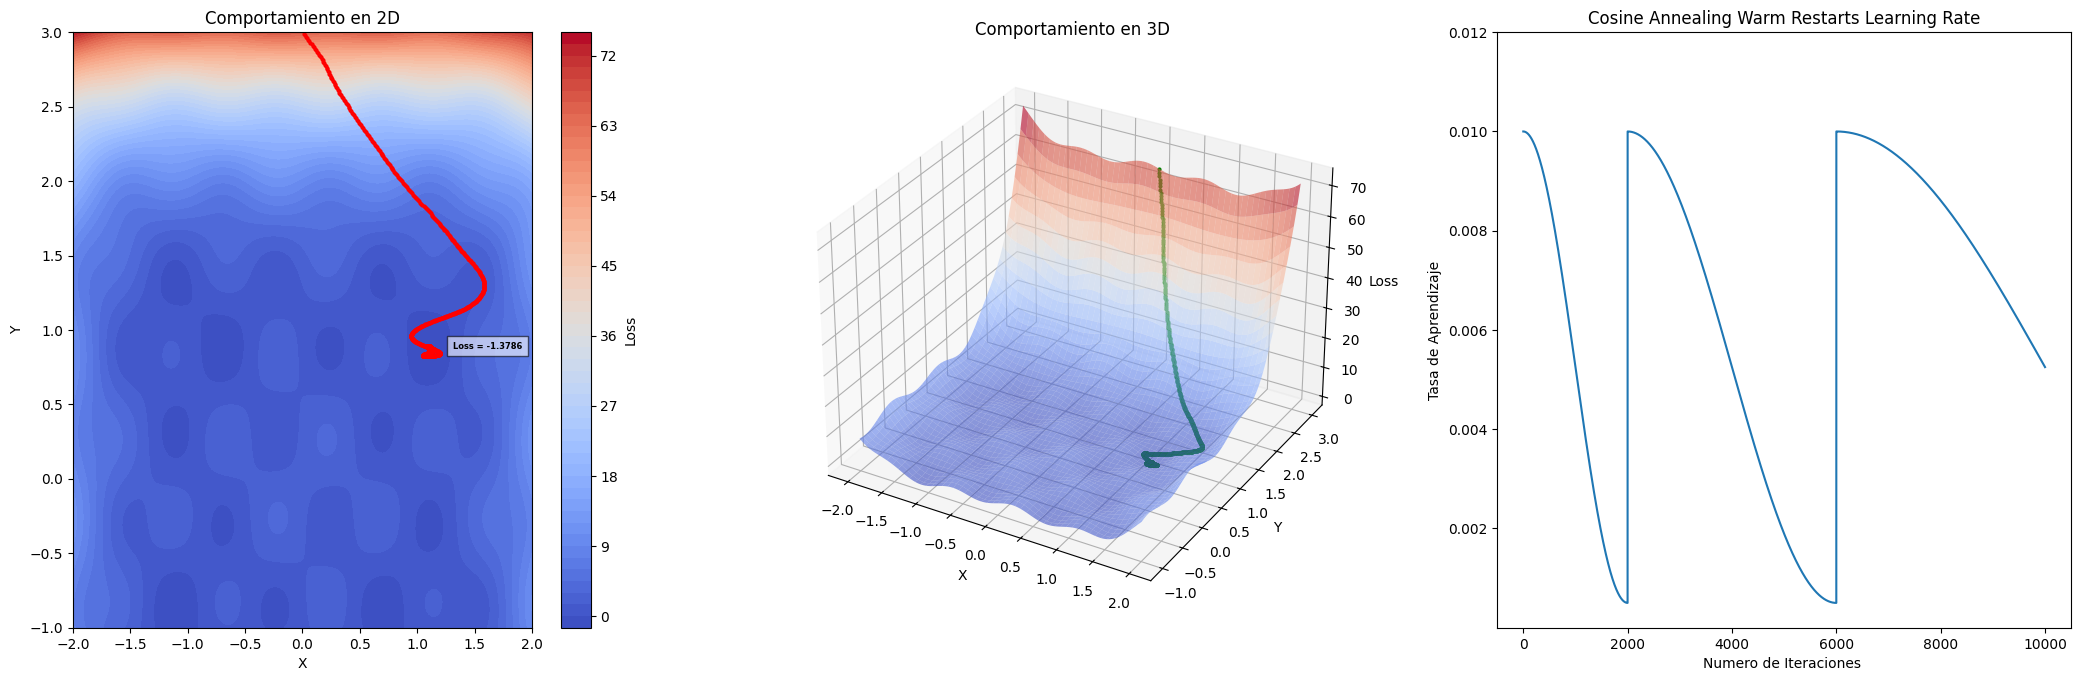

In [14]:
# Calculamos 

params = torch.tensor([0.0, 3.0], requires_grad = True)

adam_optimizer = Adam(params = [params], lr = 0.01, betas = (0.99, 0.999), eps = 1e-8)

# Scheduler 

lr_scheduler = CosineAnnealingWarmRestarts(optimizer = adam_optimizer, eta_min = 0.0005, T_0 = 2000, T_mult = 2)

loss, params, grads, learning_rates = train_fuction(n_iterations = 10000, optimizer = adam_optimizer, scheduler = lr_scheduler)  

# Visualizamos 

plot_function(loss, params, learning_rates, loss_fn = loss_function, n_iterations = 10000, name = 'Cosine Annealing Warm Restarts Learning Rate')

# **Chained Scheduler**

* Permite encadenar múltiples estrategias de ajuste de la tasa de aprendizaje. Cada scheduler se aplica secuencialmente sobre la tasa de aprendizaje resultante del scheduler anterior.

**Nota:** Si varios schedulers coinciden en el mismo paso, se aplican en orden, usando el resultado del scheduler previo como entrada para el siguiente.

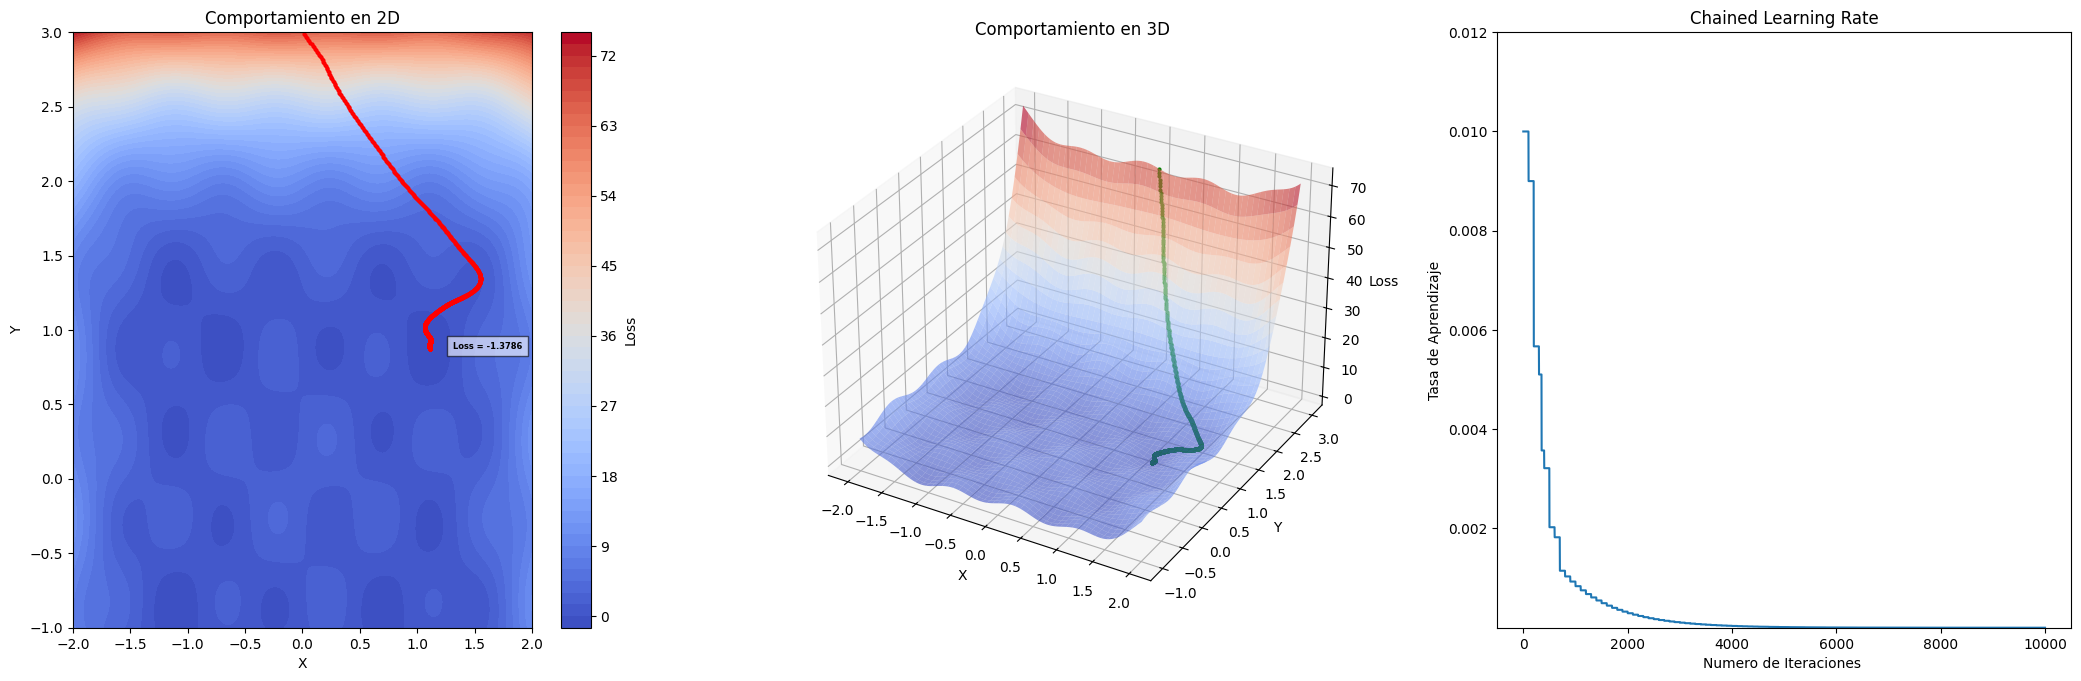

In [15]:
# Calculamos 

params = torch.tensor([0.0, 3.0], requires_grad = True)

adam_optimizer = Adam(params = [params], lr = 0.01, betas = (0.99, 0.999), eps = 1e-8)

# Scheduler 

lr_scheduler_1 = StepLR(optimizer = adam_optimizer, step_size = 100, gamma = 0.9)
lr_scheduler_2 = MultiStepLR(optimizer = adam_optimizer, milestones = [200, 350, 500, 700], gamma = 0.7)

lr_scheduler = ChainedScheduler(schedulers = [lr_scheduler_1, lr_scheduler_2], optimizer = adam_optimizer)

loss, params, grads, learning_rates = train_fuction(n_iterations = 10000, optimizer = adam_optimizer, scheduler = lr_scheduler)  

# Visualizamos 

plot_function(loss, params, learning_rates, loss_fn = loss_function, n_iterations = 10000, name = 'Chained Learning Rate')

# **Sequential Learning Rate**

El Sequential Learning Rate depende de **un parametro**:

* $\text{milestones}$ = Indica los puntos en los que se pasa de un scheduler a otro (Si hay mas schedulers, la longitud de la lista milestones tienes que ser $len(\text{schedulers}) - 1$)


**Nota:** Se ejecuta el primer scheduler, se retorna a la Tasa de Aprendizaje Incial y se empieza a aplicar el segundo scheduler y asi sucesivamente para $n$ schedulers

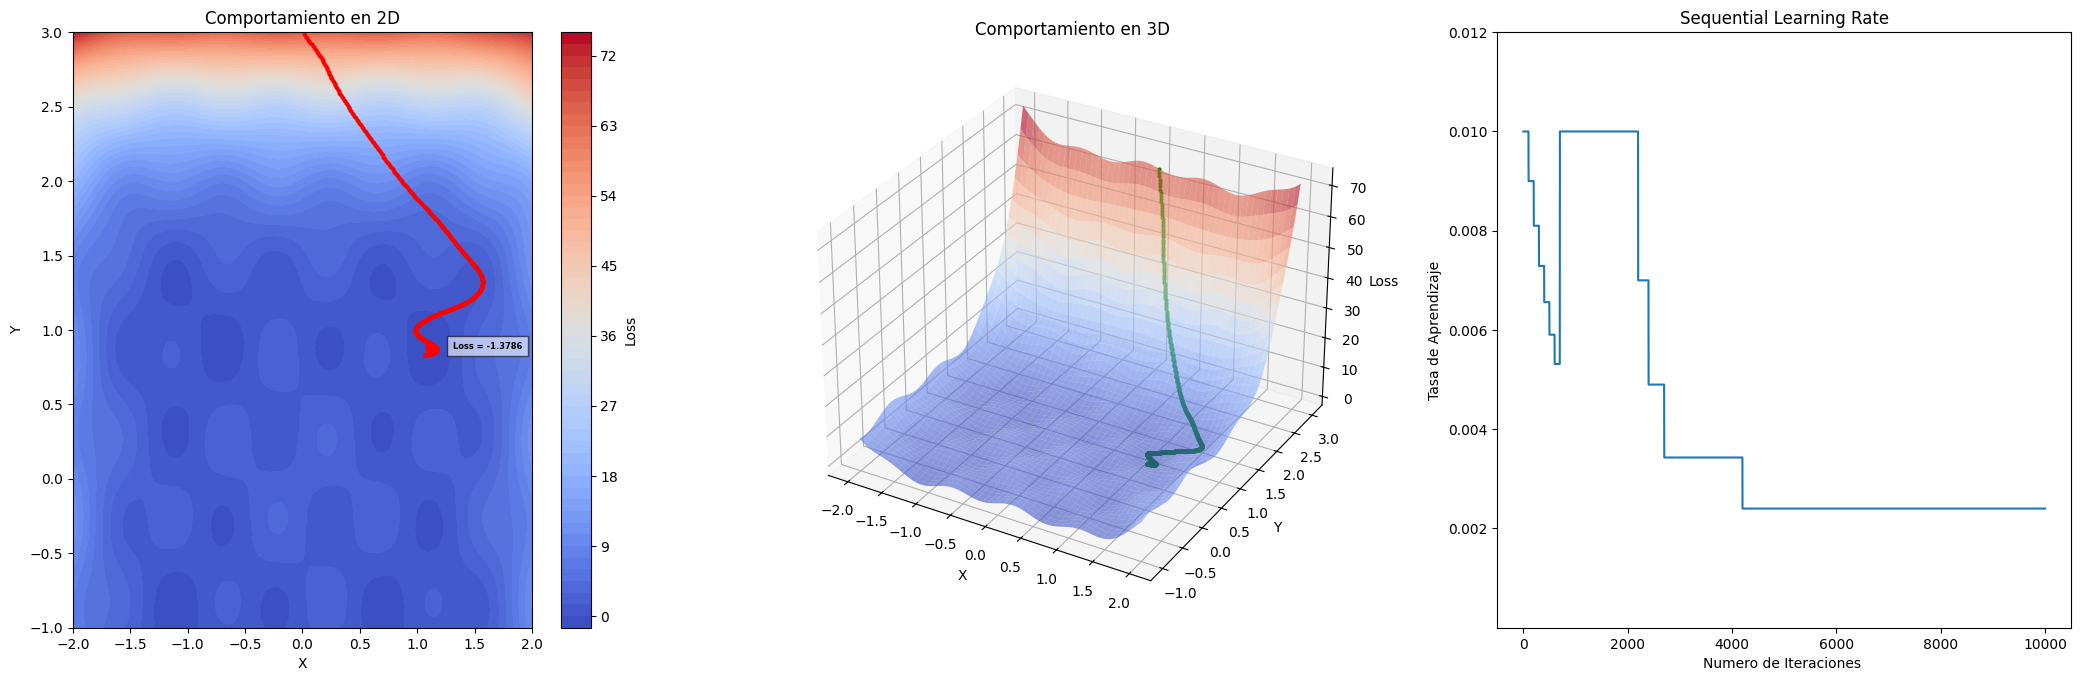

In [16]:
# Calculamos 

params = torch.tensor([0.0, 3.0], requires_grad = True)

adam_optimizer = Adam(params = [params], lr = 0.01, betas = (0.99, 0.999), eps = 1e-8)

# Scheduler 

lr_scheduler_1 = StepLR(optimizer = adam_optimizer, step_size = 100, gamma = 0.9)
lr_scheduler_2 = MultiStepLR(optimizer = adam_optimizer, milestones = [1500, 1700, 2000, 3500], gamma = 0.7)

lr_scheduler = SequentialLR(schedulers = [lr_scheduler_1, lr_scheduler_2], optimizer = adam_optimizer, milestones = [700])

loss, params, grads, learning_rates = train_fuction(n_iterations = 10000, optimizer = adam_optimizer, scheduler = lr_scheduler)  

# Visualizamos 

plot_function(loss, params, learning_rates, loss_fn = loss_function, n_iterations = 10000, name = 'Sequential Learning Rate')